In [1]:
import re
import nltk
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# All News

This dataset contains 2.7 million articles from 26 different publications from January 2016 to April 1, 2020.

* source: https://components.one/datasets/all-the-news-2-news-articles-dataset/

## 1. Acquire data

In [11]:
# Reading a sample file
news = pd.read_csv(
    'all-the-news-2-1.csv', 
    usecols=['date', 'title', 'article'],
    parse_dates=['date'],
    nrows=5000
)

In [12]:
# Concatenate title with article
news['document'] = news['title'] + ' ' + news['article']
news.drop(['title', 'article'], axis=1, inplace=True)

In [13]:
# Drop null
news = news.dropna()

In [14]:
# Displaying head
news.head()

,date,document
0,2016-12-09 18:31:00,We should take concerns about the health of li...
1,2016-10-07 21:26:46,Colts GM Ryan Grigson says Andrew Luck's contr...
2,2018-01-26 00:00:00,Trump denies report he ordered Mueller fired D...
3,2019-06-27 00:00:00,France's Sarkozy reveals his 'Passions' but in...
4,2016-01-27 00:00:00,Paris Hilton: Woman In Black For Uncle Monty's...


In [15]:
print(news.shape)
print('Min:', news.date.min(), '| Max:', news.date.max())

(4987, 2)
Min: 2016-01-02 00:00:00 | Max: 2019-07-12 00:00:00


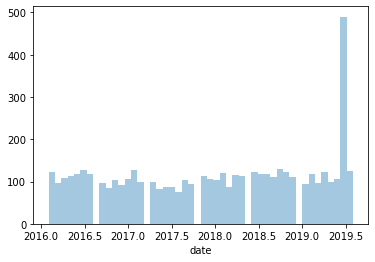

In [16]:
# Monthly distribution
sns.distplot(news.date.dt.year + news.date.dt.month/12 , bins=48, kde=False)

## 2. Preprocessing data


### 2.1. Cleaning the data


In [17]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "")
    df[text_field] = df[text_field].str.lower()
    return df

clean_news = standardize_text(news, "document")

clean_news.head()

,date,document
0,2016-12-09 18:31:00,we should take concerns about the health of li...
1,2016-10-07 21:26:46,colts gm ryan grigson says andrew luck's contr...
2,2018-01-26 00:00:00,trump denies report he ordered mueller fired d...
3,2019-06-27 00:00:00,france's sarkozy reveals his 'passions' but in...
4,2016-01-27 00:00:00,paris hilton woman in black for uncle monty's...


### 2.2. Tokenization & Removing Stop Words & Lemmatization

In [18]:
# Stemmer
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [19]:
clean_news['tokens'] = clean_news['document'].apply(preprocess)
clean_news.head()

,date,document,tokens
0,2016-12-09 18:31:00,we should take concerns about the health of li...,"[concern, health, liber, democraci, serious, p..."
1,2016-10-07 21:26:46,colts gm ryan grigson says andrew luck's contr...,"[colt, ryan, grigson, say, andrew, luck, contr..."
2,2018-01-26 00:00:00,trump denies report he ordered mueller fired d...,"[trump, deni, report, order, mueller, fire, da..."
3,2019-06-27 00:00:00,france's sarkozy reveals his 'passions' but in...,"[franc, sarkozi, reveal, passion, insist, come..."
4,2016-01-27 00:00:00,paris hilton woman in black for uncle monty's...,"[pari, hilton, woman, black, uncl, monti, fune..."


In [21]:
# Count words by document
clean_news['length'] = clean_news.tokens.apply(lambda x: len(x))

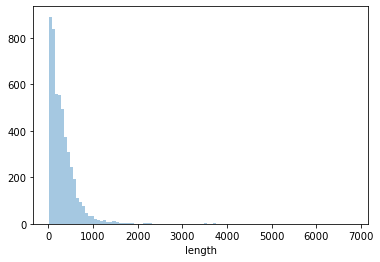

In [24]:
# Length distribution
sns.distplot(clean_news.length , bins=100, kde=False)

### 2.3. Bag of Words Count

In [35]:
dictionary = gensim.corpora.Dictionary(clean_news.tokens)

count = 0
for _ in dictionary.iteritems():
    count += 1

print('{} words in vocabulary'.format(count))

41940 words in vocabulary


In [43]:
# Bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in clean_news.tokens]

In [49]:
# Check an example
bow_corpus_1 = bow_corpus[1]

for i in range(len(bow_corpus_1))[:4]:
    print("Word {} (\"{}\") appears {} time.".format(bow_corpus_1[i][0], dictionary[bow_corpus_1[i][0]], bow_corpus_1[i][1]))

Word 25 ("build") appears 3 time.
Word 30 ("certain") appears 1 time.
Word 41 ("come") appears 1 time.
Word 60 ("develop") appears 1 time.


### 2.4. Tf-Idf Model

In [51]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [54]:
# Check an example
tfidf_corpus_1 = corpus_tfidf[1]

for i in range(len(tfidf_corpus_1))[:4]:
    print("Word {} (\"{}\") has {:.4} for score.".format(tfidf_corpus_1[i][0], dictionary[tfidf_corpus_1[i][0]], tfidf_corpus_1[i][1]))

Word 25 ("build") has 0.06214 for score.
Word 30 ("certain") has 0.02363 for score.
Word 41 ("come") has 0.01009 for score.
Word 60 ("develop") has 0.02261 for score.


## 3. Modeling topics
### 3.1. BoW

In [55]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [56]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"say" + 0.009*"year" + 0.006*"like" + 0.006*"peopl" + 0.005*"time" + 0.005*"think" + 0.005*"go" + 0.004*"compani" + 0.004*"know" + 0.004*"work"
Topic: 1 
Words: 0.007*"like" + 0.007*"peopl" + 0.006*"say" + 0.005*"year" + 0.005*"work" + 0.005*"time" + 0.003*"think" + 0.003*"report" + 0.003*"come" + 0.003*"know"
Topic: 2 
Words: 0.011*"say" + 0.009*"like" + 0.006*"peopl" + 0.005*"year" + 0.005*"think" + 0.005*"time" + 0.004*"work" + 0.004*"tell" + 0.004*"know" + 0.003*"want"
Topic: 3 
Words: 0.007*"say" + 0.007*"like" + 0.006*"trump" + 0.006*"peopl" + 0.006*"republican" + 0.006*"think" + 0.004*"go" + 0.004*"democrat" + 0.004*"time" + 0.004*"know"
Topic: 4 
Words: 0.009*"say" + 0.009*"like" + 0.006*"think" + 0.006*"trump" + 0.005*"peopl" + 0.005*"time" + 0.005*"year" + 0.004*"facebook" + 0.004*"go" + 0.004*"know"
Topic: 5 
Words: 0.009*"option" + 0.009*"section" + 0.009*"previous" + 0.009*"expand" + 0.009*"indic" + 0.009*"icon" + 0.008*"navig" + 0.008*"chevron" + 0.

### 3.2. TF-IDF

In [70]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [71]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.001*"trump" + 0.001*"republican" + 0.001*"say" + 0.001*"peopl" + 0.001*"like" + 0.001*"china" + 0.001*"state" + 0.001*"year" + 0.001*"work" + 0.001*"korea"
Topic: 1 Word: 0.001*"trump" + 0.001*"democrat" + 0.001*"elect" + 0.001*"vote" + 0.001*"say" + 0.001*"state" + 0.001*"republican" + 0.001*"campaign" + 0.001*"clinton" + 0.001*"brexit"
Topic: 2 Word: 0.001*"trump" + 0.001*"say" + 0.001*"compani" + 0.000*"peopl" + 0.000*"presid" + 0.000*"state" + 0.000*"like" + 0.000*"women" + 0.000*"million" + 0.000*"democrat"
Topic: 3 Word: 0.002*"trump" + 0.001*"mueller" + 0.001*"presid" + 0.001*"republican" + 0.001*"democrat" + 0.001*"trade" + 0.001*"saudi" + 0.001*"state" + 0.001*"percent" + 0.001*"china"
Topic: 4 Word: 0.001*"trump" + 0.001*"chevron" + 0.001*"menu" + 0.001*"navig" + 0.001*"icon" + 0.001*"section" + 0.001*"facebook" + 0.001*"option" + 0.001*"compani" + 0.001*"expand"
Topic: 5 Word: 0.001*"trump" + 0.001*"senat" + 0.001*"republican" + 0.001*"bank" + 0.001*"democra

### 4. Evaluation

In [72]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9956902265548706	 
Topic: 0.016*"trump" + 0.009*"say" + 0.007*"peopl" + 0.006*"time" + 0.006*"like" + 0.004*"go" + 0.004*"report" + 0.004*"presid" + 0.004*"know" + 0.004*"tell"


In [73]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6061391830444336	 
Topic: 0.002*"trump" + 0.001*"compani" + 0.001*"china" + 0.001*"peopl" + 0.001*"say" + 0.001*"like" + 0.001*"artist" + 0.001*"work" + 0.001*"think" + 0.001*"presid"

Score: 0.33250996470451355	 
Topic: 0.002*"trump" + 0.001*"republican" + 0.001*"democrat" + 0.001*"vote" + 0.001*"brexit" + 0.001*"korea" + 0.001*"presid" + 0.001*"immigr" + 0.001*"say" + 0.001*"deal"

Score: 0.05794994533061981	 
Topic: 0.002*"trump" + 0.001*"mueller" + 0.001*"presid" + 0.001*"republican" + 0.001*"democrat" + 0.001*"trade" + 0.001*"saudi" + 0.001*"state" + 0.001*"percent" + 0.001*"china"
